# Titanic: Machine Learning from Disaster (TensorFlow Linear Classifier)

A comprehensive analysis and machine learning modeling of Kaggle's Titanic dataset.



## Setup

Import libraries and upload data

In [401]:
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt

In [402]:
from google.colab import files
files.upload()

{}

Construct pandas dataframes from csv files and extract dependent variables (in this case, 'Survived')

In [457]:
dftrain = pd.read_csv('train.csv')
dftest = pd.read_csv('test.csv')
ytrain_all = dftrain.pop('Survived')
ids = dftest['PassengerId']

In [458]:
ids

0       892
1       893
2       894
3       895
4       896
       ... 
413    1305
414    1306
415    1307
416    1308
417    1309
Name: PassengerId, Length: 418, dtype: int64

## Data

#### Variable Notes

---

pclass: A proxy for socio-economic status (SES)

1st = Upper

2nd = Middle

3rd = Lower

---

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

---

sibsp: The dataset defines family relations in this way...

Sibling = brother, sister, stepbrother, stepsister

Spouse = husband, wife (mistresses and fiancés were ignored)

---

parch: The dataset defines family relations in this way...

Parent = mother, father

Child = daughter, son, stepdaughter, stepson

Some children travelled only with a nanny, therefore parch=0 for them.

#### Initial Plots

In [404]:
dftrain.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [405]:
dftest.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


Text(0.5, 0, 'Age')

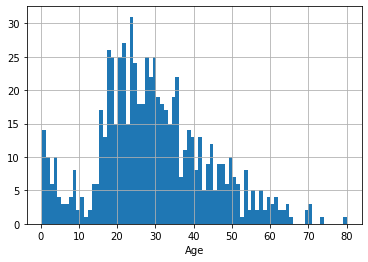

In [406]:
dftrain['Age'].hist(bins=80).set_xlabel('Age')

Text(0.5, 0, 'Fare')

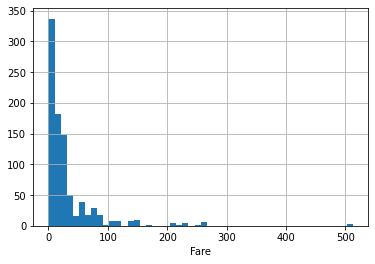

In [407]:
dftrain['Fare'].hist(bins=50).set_xlabel('Fare')

[Text(0.5, 0, 'Population')]

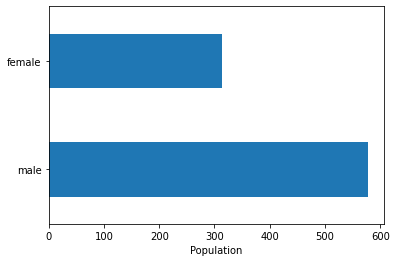

In [408]:
dftrain['Sex'].value_counts().plot(kind='barh').set(xlabel="Population")

[Text(0, 0.5, 'Class'), Text(0.5, 0, 'Population')]

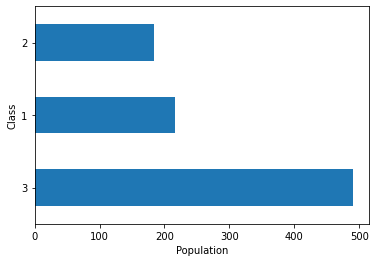

In [409]:
dftrain['Pclass'].value_counts().plot(kind='barh').set(xlabel="Population", ylabel="Class")

[Text(0, 0.5, 'Location Embarked From'), Text(0.5, 0, 'Population')]

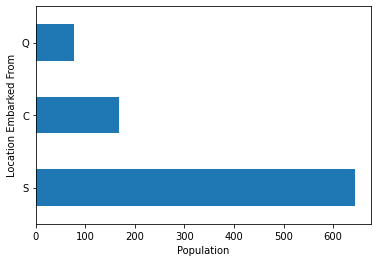

In [410]:
dftrain['Embarked'].value_counts().plot(kind='barh').set(xlabel="Population", ylabel="Location Embarked From")

Key: C = Cherbourg, Q = Queenstown, S = Southampton

[Text(0, 0.5, 'No. of Siblings & Spouses Onboard')]

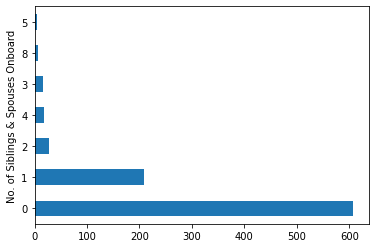

In [411]:
dftrain['SibSp'].value_counts().plot(kind='barh').set(ylabel="No. of Siblings & Spouses Onboard")

[Text(0, 0.5, 'No. of Parents & Children Onboard')]

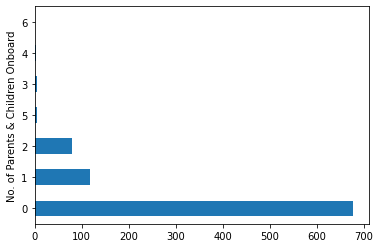

In [412]:
dftrain['Parch'].value_counts().plot(kind='barh').set(ylabel="No. of Parents & Children Onboard")

[Text(0.5, 0, 'Survival Rate')]

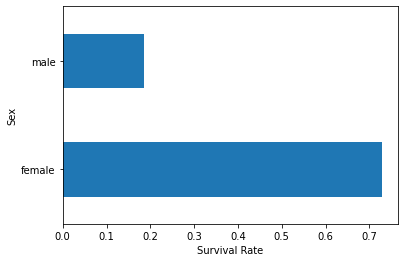

In [413]:
pd.concat([dftrain, ytrain], axis=1).groupby('Sex').Survived.mean().plot(kind='barh').set(xlabel="Survival Rate")

[Text(0, 0.5, 'Class'), Text(0.5, 0, 'Survival Rate')]

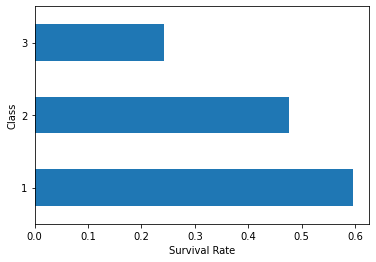

In [414]:
pd.concat([dftrain, ytrain], axis=1).groupby('Pclass').Survived.mean().plot(kind='barh').set(xlabel="Survival Rate", ylabel="Class")

At a first glance:
*   Median age is 20-30 years
*   Male population almost doubles female
*   Most passengers are in third class, followed by first which is closely followed by second
*   Large portion of population either with no spouses/siblings or no parents/children
*   Women have a far higher survival chance than men
*   Privelage of the wealthy; higher class means higher survival rate







## Feature Engineering

Let's engineer a few additional (non-polynomial) features. Some ideas:
*   What deck are they on? This corresponds to the first letter on their cabin number
*   Are they alone?
*   What is the total number of family members onboard? (Parch + SibSp)
*   What titles do they have in their name?
*   Group age into bins
*   Group fares into bins

Note that adding too many features can lead to high variance, which is not good for accuracy when working with small datasets.


In [415]:
def get_title(name):
  title = re.search(' ([A-Za-z]+)\.', name)
  if title:
    return title.group(1)
  return np.nan

def eng_features(df):
  if 'Cabin' in df.columns:
    df['Deck'] = df['Cabin'].str.get(0)
  df['Alone'] = (df['SibSp']*df['Parch']==0)*1
  df['Family'] = df['SibSp'] + df['Parch']
  if 'Age' in df.columns:
    df['Age Group'] = pd.cut(df['Age'], bins=[0,12,20,40,120], 
                          labels=['Children','Teenage','Adult','Elder'])
  if 'Fare' in df.columns:
    df['Fare Group'] = pd.cut(df['Fare'], bins=[-1,7.91,14.45,31,1000], 
                            labels=['Low','Medium','High','Very High'])
  if 'Name' in df.columns:
    df['Title'] = df['Name'].apply(get_title)
    df['Title'] = df['Title'].replace(['Lady', 'Countess', 'Capt',
          'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    df['Title'] = df['Title'].replace('Mlle', 'Miss')
    df['Title'] = df['Title'].replace('Ms', 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')
  return df

In [416]:
dftrain = eng_features(dftrain)
dftest = eng_features(dftest)

#### Missing Data

Let's examine the missing data

In [417]:
dftrain.isnull().sum() + dftest.isnull().sum()

PassengerId       0
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
Deck           1014
Alone             0
Family            0
Age Group       263
Fare Group        1
Title             0
dtype: int64

We need to fill in Age, Fare, Cabin, and Embarked which automatically fill additional columns. For numerical columns, we replace NaN elements with their column's respective median value. For category columns, we introduce a new category for NaN values. Finally, remove Age, Fare, and other unneccessary features.

In [418]:
def clean_data(df):
  if {'Age', 'Fare'}.issubset(df.columns):
    df['Age'] = df['Age'].fillna(df['Age'].median())
    df['Fare'] = df['Fare'].fillna(df['Fare'].median())
  df['Deck'] = df['Deck'].fillna('Missing')
  df['Embarked'] = df['Embarked'].fillna('Stowaway')
  if {'Name', 'Ticket', 'Cabin'}.issubset(df.columns):
    df = df.drop(columns=['Name', 'Ticket', 'Cabin', 'PassengerId']) # Drop unecessary features
  df = eng_features(df) # re-engineer features
  if {'Age', 'Fare'}.issubset(df.columns):
    df = df.drop(columns=['Age', 'Fare']) # Drop Age & Fare
  return df

dftrain = clean_data(dftrain)
dftest = clean_data(dftest)

Check that there are no longer any nan elements

In [419]:
dftrain.isnull().sum() + dftest.isnull().sum()

Pclass        0
Sex           0
SibSp         0
Parch         0
Embarked      0
Deck          0
Alone         0
Family        0
Age Group     0
Fare Group    0
Title         0
dtype: int64

#### Encoding Categorical Data

Proceed to encode categorical data using sklearn's OneHotEncoder

In [420]:
dfall = pd.concat([dftrain,dftest], keys=['dftrain', 'dftest'])
dfall.xs('dftrain')

,Pclass,Sex,SibSp,Parch,Embarked,Deck,Alone,Family,Age Group,Fare Group,Title
0,3,male,1,0,S,Missing,1,1,Adult,Low,Mr
1,1,female,1,0,C,C,1,1,Adult,Very High,Mrs
2,3,female,0,0,S,Missing,1,0,Adult,Medium,Miss
3,1,female,1,0,S,C,1,1,Adult,Very High,Mrs
4,3,male,0,0,S,Missing,1,0,Adult,Medium,Mr
...,...,...,...,...,...,...,...,...,...,...,...
886,2,male,0,0,S,Missing,1,0,Adult,Medium,Rare
887,1,female,0,0,S,B,1,0,Teenage,High,Miss
888,3,female,1,2,S,Missing,0,3,Adult,High,Miss
889,1,male,0,0,C,C,1,0,Adult,High,Mr


In [421]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# 
def encode_categ(df):
  categorical_columns = ['Pclass','Sex','Embarked','Deck', 'Age Group', 'Fare Group', 'Title']
  # 'passthrough' retains other featuer columns
  ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), categorical_columns)], remainder='passthrough')
  M = ct.fit_transform(df)
  return M

Xtrain = encode_categ(dftrain)
Xtest = encode_categ(dftest)

In [422]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

def encode_categ(dftrain, dftest):
  # Concantenate dftrain and dfall to ensure column correspondence
  dfall = pd.concat([dftrain, dftest])
  categorical_columns = ['Pclass','Sex','Embarked','Deck', 'Age Group', 'Fare Group', 'Title']
  # 'passthrough' retains other featuer columns
  ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), categorical_columns)], remainder='passthrough')
  dfall_np = ct.fit_transform(dfall)
  Xtrain = dfall_np[:dftrain.shape[0],:]
  Xtest = dfall_np[dftrain.shape[0]:,:]
  return Xtrain, Xtest

Xtrain_all, Xtest = encode_categ(dftrain, dftest)

In [423]:
ytrain.shape

(623,)

## Models

Now that we have analyzed and cleaned the data, as well as performed feature analysis, we move on to model selection. There are a variety of machine learning models that may be implemented to predict the survivability outcome, so we will test a number of well known models and compare performance.

Let us implement 6 different ML models:

1.   Logistic Regression
2.   K-Nearest Neighbours (KNN) Classifier
3.   Support Vector Machine (SVM)
4.   Naive Bayes
5.   Decision Tree Classification
6.   Random Forest Classification

In [424]:
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score

from sklearn.model_selection import GridSearchCV

We will construct a function that splits and shuffles our training set into a training set and evaluation set. It then trains and evaluates the accuracy of the input model several times over a loop and returns the mean accuracy.

In [425]:
def mean_accuracy(model, n=100):
  accuracy_arr = np.array([])
  for i in range(n):
    Xtrain, Xeval, ytrain, yeval = train_test_split(Xtrain_all, ytrain_all, test_size = 0.3)
    model.fit(Xtrain, ytrain)
    prediction = model.predict(Xeval)
    accuracy = accuracy_score(prediction, yeval)
    accuracy_arr = np.append(accuracy_arr, accuracy)
  return accuracy_arr.mean()

#### Logistic Regression

In [435]:
model = LogisticRegression()
accuracy_lr = mean_accuracy(model)
print(f'Logistic regression classifier achieves an average accuracy of {round(accuracy_lr,4)*100}%')

Logistic regression classifier achieves an average accuracy of 83.00999999999999%


#### K-Nearest Neighbours

In [427]:
model = KNeighborsClassifier(n_neighbors = 10)
accuracy_knn = mean_accuracy(model)

print(f'KNN classifier achieves an accuracy of {round(accuracy_knn,4)*100}%')

KNN classifier achieves an accuracy of 81.17999999999999%


#### Support Vector Machine

In [434]:
model = SVC()
accuracy_svm = mean_accuracy(model)

print(f'SVM classifier achieves an accuracy of {round(accuracy_svm,4)*100}%')

SVM classifier achieves an accuracy of 83.27%


#### Naive Bayes (Gaussian)

In [429]:
model = GaussianNB()
accuracy_nb = mean_accuracy(model)

print(f'Naive Bayes classifier achieves an accuracy of {round(accuracy_nb,4)*100}%')

Naive Bayes classifier achieves an accuracy of 76.7%


#### Decision Tree

In [430]:
model = DecisionTreeClassifier()
accuracy_dt = mean_accuracy(model)

print(f'Decision Tree classifier achieves an accuracy of {round(accuracy_dt,4)*100}%')

Decision Tree classifier achieves an accuracy of 79.86%


#### Random Forest Classifier

In [431]:
model = RandomForestClassifier(criterion='gini', n_estimators=700,
                             min_samples_split=10,min_samples_leaf=1,
                             max_features='auto',oob_score=True,
                             random_state=1,n_jobs=-1)

accuracy_rf = mean_accuracy(model)

print(f'Random Forest classifier achieves an accuracy of {round(accuracy_rf,4)*100}%')

Random Forest classifier achieves an accuracy of 82.34%


## Model Selection

#### Model Comparison

Let's compare the models we've tested so far.

In [436]:
models = pd.DataFrame({
    'Model': ['Logistic Regression', 'KNN', 'SVM',
              'Naive Bayes', 'Decision Tree', 'Random Forest'],
    'Accuracy': [accuracy_lr, accuracy_knn, accuracy_svm,
              accuracy_nb, accuracy_dt, accuracy_rf]})
models.sort_values(by='Accuracy',ascending=False)

,Model,Accuracy
2,SVM,0.832724
0,Logistic Regression,0.830075
5,Random Forest,0.823358
1,KNN,0.811828
4,Decision Tree,0.798582
3,Naive Bayes,0.766978


Both logistic regression and SVM achieve roughly the highest accuracy, with random forest following.

The classifiers imported from sklearn are a sort of blackbox with tunable parameters that impact model performance. By employing GridSearchCV, we can further tune this parameters space to ensure the highest accuracy model. On the otherhand, beware of overfitting due to over-tuning parameters.

In [ ]:
# LogisticRegression().get_params()
# SVC().get_params()
# RandomForestClassifier().get_params()

#### Logistic Regression Parameters Tuning

In [438]:
model = LogisticRegression()
param_grid = {'C': [1, 10, 50, 100, 200, 300, 1000],
              'fit_intercept': [True, False]}

model_lr = GridSearchCV(model, param_grid = param_grid, cv=5, scoring="accuracy", n_jobs= 4, verbose = 1)

Xtrain, Xeval, ytrain, yeval = train_test_split(Xtrain_all, ytrain_all, test_size = 0.3)
model_lr.fit(Xtrain, ytrain)

# Best parameters
print(model_lr.best_estimator_)

# Best score
print(f'Ideal LR parameters achieve an accuracy of {round(model_lr.best_score_,4)*100}%')

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.3s


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Ideal LR parameters achieve an accuracy of 82.82000000000001%


[Parallel(n_jobs=4)]: Done  63 out of  70 | elapsed:    3.8s remaining:    0.4s
[Parallel(n_jobs=4)]: Done  70 out of  70 | elapsed:    3.9s finished


In [447]:
model = LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

accuracy_lr_tuned = mean_accuracy(model)
print(f'Fine-Tuned SVM classifier achieves an accuracy of {round(accuracy_lr_tuned,4)*100}%')

Fine-Tuned SVM classifier achieves an accuracy of 82.52000000000001%


#### SVM Parameters Tuning

In [440]:
model = SVC()
param_grid = {'kernel': ['rbf', 'linear'], 
              'gamma': [ 0.001, 0.01, 0.1, 1],
              'C': [1, 10, 50, 100, 200, 300, 1000]}

model_svm = GridSearchCV(model, param_grid = param_grid, cv=5, scoring="accuracy", n_jobs= 4, verbose = 1)

Xtrain, Xeval, ytrain, yeval = train_test_split(Xtrain_all, ytrain_all, test_size = 0.3)
model_svm.fit(Xtrain, ytrain)

# Best parameters
print(model_svm.best_estimator_)

# Best score
print(f'Ideal SVM parameters achieve an accuracy of {round(model_svm.best_score_,4)*100}%')

Fitting 5 folds for each of 56 candidates, totalling 280 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    4.0s


SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Ideal SVM parameters achieve an accuracy of 82.66%


[Parallel(n_jobs=4)]: Done 280 out of 280 | elapsed:   45.7s finished


In [446]:
model = SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

accuracy_svm_tuned = mean_accuracy(model)
print(f'Fine-Tuned SVM classifier achieves an accuracy of {round(accuracy_svm_tuned,4)*100}%')

Fine-Tuned SVM classifier achieves an accuracy of 82.53%


#### Random Forest Parameters Tuning

In [442]:
model = RandomForestClassifier()
n_estim = range(100, 1000, 100)
param_grid = {'n_estimators' : n_estim}

model_rf = GridSearchCV(model, param_grid = param_grid, cv=5, scoring="accuracy", n_jobs= 4, verbose = 1)

Xtrain, Xeval, ytrain, yeval = train_test_split(Xtrain_all, ytrain_all, test_size = 0.3)
model_rf.fit(Xtrain, ytrain)

# Best parameters
print(model_rf.best_estimator_)

# Best score
print(f'Ideal RF parameters achieve an accuracy of {round(model_rf.best_score_,4)*100}%')

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:   32.5s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Ideal RF parameters achieve an accuracy of 83.94%


In [443]:
model = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=900,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

accuracy_rf_tuned = mean_accuracy(model)
print(f'Fine-Tuned Random Forest classifier achieves an accuracy of {round(accuracy_rf_tuned,4)*100}%')

Fine-Tuned Random Forest classifier achieves an accuracy of 81.67%


#### Final Comparison

In [448]:
models = pd.DataFrame({
    'Hyper-Tuned Model': ['Logistic Regression', 'SVM', 'Random Forest'],
    'Accuracy': [accuracy_lr_tuned, accuracy_svm_tuned, accuracy_rf_tuned]})
models.sort_values(by='Accuracy',ascending=False)

,Hyper-Tuned Model,Accuracy
1,SVM,0.825299
0,Logistic Regression,0.825224
2,Random Forest,0.816679


It seems that hyper-tuned SVM and Logistic Regression have approximately the same performance. For our predictions, we will implement the Logistic Regression classifier.

## Final Prediction & Submission

Finally, train our LR model using the entire training set and predict survivability for the test set. Save prediction as a csv file.

In [474]:
model = LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

model.fit(Xtrain_all, ytrain_all)
final_prediction = model.predict(Xtest)

In [476]:
submission = pd.DataFrame(ids)
submission['Survived'] = final_prediction
submission.to_csv('titanicmain_submission.csv', index=False)

files.download('titanicmain_submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>